# Анализ бизнес-показателей

Нам предстоит изучить данные приложения Procrastinate Pro+, провести исследования, оценить эффективность маркетинговых вложений.
- На первом этапе мы загрузим и подготовим данные - посмотрим, есть ли в исходных файлах пропуски и дубликаты, приведем в соответствие типы данных и добавим необходимые столбцы.
- Потом мы зададим формулы для расчета метрик и построения графиков.
- Проведем исследовательский анализ
- Оценим инвестиции в маркетинг

Загрузим необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta


Загрузим исходные данные (вырианты для просмотра локально и через браузер)

In [2]:
try:
    visits = pd.read_csv('visits_info_short.csv')
except:
    visits = pd.read_csv('/datasets/visits_info_short.csv')
try:
    orders = pd.read_csv('orders_info_short.csv')
except:
    orders = pd.read_csv('/datasets/orders_info_short.csv')
try:
    costs = pd.read_csv('costs_info_short.csv')
except:
    costs = pd.read_csv('/datasets/costs_info_short.csv')

### Предобработка данных

#### visits

Посмотрим на данные с визитами пользователей

In [3]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


Пропусков нет, но нужно переименовать столбцы и исправить формат данных для начала и конца сессий

In [4]:
visits.columns = visits.columns.str.lower().str.replace(' ', '_')

visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        309901 non-null  int64         
 1   region         309901 non-null  object        
 2   device         309901 non-null  object        
 3   channel        309901 non-null  object        
 4   session_start  309901 non-null  datetime64[ns]
 5   session_end    309901 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 14.2+ MB


In [5]:
display(visits['session_start'].min(), visits['session_start'].max())
display(visits['session_end'].min(), visits['session_end'].max())

Timestamp('2019-05-01 00:00:41')

Timestamp('2019-10-31 23:59:23')

Timestamp('2019-05-01 00:07:06')

Timestamp('2019-11-01 01:38:46')

В выгрузке представлены данные с мая по ноябрь 2019. Теперь посмотрим, нет ли в категориальных данных дубликатов

In [6]:
display(visits['region'].unique())
display(visits['device'].unique())
display(visits['channel'].unique())

array(['United States', 'UK', 'France', 'Germany'], dtype=object)

array(['iPhone', 'Mac', 'Android', 'PC'], dtype=object)

array(['organic', 'TipTop', 'RocketSuperAds', 'YRabbit', 'FaceBoom',
       'MediaTornado', 'AdNonSense', 'LeapBob', 'WahooNetBanner',
       'OppleCreativeMedia', 'lambdaMediaAds'], dtype=object)

Посмотрим внимательнее на даты начала и окончания сессий. Нет ли случаев, когда окончание раьше начала?

In [7]:
visits[visits['session_end'] < visits['session_start']]

,user_id,region,device,channel,session_start,session_end


Проверим, есть ли в таблице полные дубликаты

In [8]:
visits.duplicated().sum()

0

Все хорошо, дубликатов нет. Проверим аналогичным образом файл с заказами

#### orders

In [9]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


Пропусков нет, нужно переименовать столбцы и изменить тип данных для даты покупки.

In [10]:
orders.columns = orders.columns.str.lower().str.replace(' ', '_')

orders['event_dt'] = pd.to_datetime(orders['event_dt'])

In [11]:
display(orders['event_dt'].min(), orders['event_dt'].max())

Timestamp('2019-05-01 00:28:11')

Timestamp('2019-10-31 23:56:56')

In [12]:
orders['revenue'].describe()

count    40212.000000
mean         5.370608
std          3.454208
min          4.990000
25%          4.990000
50%          4.990000
75%          4.990000
max         49.990000
Name: revenue, dtype: float64

Период выгрузки по продажам совпадает с данными о сессиях. Данные о продажах распределились между 4.99 - видимо, минимальная стоимость платной версии и 49.99. Посмотрим, какого размера платежи есть в выгрузке

In [13]:
orders.pivot_table(index='revenue', values='user_id', aggfunc='count')

,user_id
revenue,
4.99,38631
5.99,780
9.99,385
19.99,204
49.99,212


Подавляющее большинство клиентов платят минимальные 4.99, но и большие суммы тоже встречаются.

Проверим, есть ли в таблице полные дубликаты

In [14]:
orders.duplicated().sum()

0

#### costs

Посмотрим на данные по расходам на маркетинг

In [15]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


Переименуем столбец Channel и поменяем тип данных для даты, проверим период в выгрузке и посмотрим уникальные значения из столбца Channel

In [16]:
costs.columns = costs.columns.str.lower().str.replace(' ', '_')

costs['dt'] = pd.to_datetime(costs['dt'])

In [17]:
display(costs['dt'].min(), costs['dt'].max())

Timestamp('2019-05-01 00:00:00')

Timestamp('2019-10-27 00:00:00')

In [18]:
costs['channel'].unique()

array(['FaceBoom', 'MediaTornado', 'RocketSuperAds', 'TipTop', 'YRabbit',
       'AdNonSense', 'LeapBob', 'OppleCreativeMedia', 'WahooNetBanner',
       'lambdaMediaAds'], dtype=object)

Проверим, есть ли в таблице полные дубликаты

In [19]:
costs.duplicated().sum()

0

Данные в порядке. Можно приступать к расчетам.

Изучив выгрузки, можно сделать вывод, что данные собираются довольно аккуратно - нет пропусков, дубликатов и аномальных значений. Некорректно отображается тип данных для дат и требуется убрать из названий столбцов пробелы и заглавные буквы. В остальном данные пригодны для анализа.

### Функции для расчета основных метрик

Для оценки маркетинговых показателей нам необходимо рассчитать конверсию, удержание, LTV и ROI. Для этого введем соответствующие функции.

#### создание профиля пользователей

In [20]:
def get_profiles(sessions, orders, events, ad_costs, event_names=[]):

    # сортируем сессии по ID пользователя и дате привлечения
    # группируем по ID и находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
         # время первого посещения назовём first_ts
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()  # возвращаем user_id из индекса
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # добавляем флаги для всех событий из event_names
    for event in event_names:
        if event in events['event_name'].unique():
            # проверяем, встречается ли каждый пользователь
            # среди тех, кто совершил событие event
            profiles[event] = profiles['user_id'].isin(
                events.query('event_name == @event')['user_id'].unique()
            )

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
         # столбец с числом пользователей назовём unique_users
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()  # возвращаем dt и channel из индексов
    )

    new_users['dt'] = new_users['dt'].astype('datetime64')
    profiles['dt'] = profiles['dt'].astype('datetime64')
    # объединяем траты на рекламу и число привлечённых пользователей
    # по дате и каналу привлечения
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    # результаты сохраним в столбец acquisition_cost (CAC)
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавим стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # органические пользователи не связаны с данными о рекламе,
    # поэтому в столбце acquisition_cost у них значения NaN
    # заменим их на ноль, ведь стоимость привлечения равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)
    
    return profiles

#### функция коэффициента удержания

In [21]:
def get_retention(profiles, sessions, observation_date, horizon_days, dimensions = [], ignore_horizon = False):
    
    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions
    
    # исключаем пользователей, не «доживших» до горизонта анализа 
    # тех, которые присоединились позже, чем observation_date - horizon
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(days = horizon_days - 1)
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(sessions[['user_id', 'session_start']], on = 'user_id', how = 'left')
    result_raw['lifetime'] = (result_raw['session_start'] - result_raw['first_ts']).dt.days
    
    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):     
        # строим «треугольную таблицу» 
        result = df.pivot_table(index = dims, columns = 'lifetime', values = 'user_id', aggfunc = 'nunique')     
        # определяем размеры когорт
        cohort_sizes = df.groupby(dims).agg({'user_id': 'nunique'}).rename(columns = {'user_id': 'cohort_size'}) 
        # присоединяем размеры когорт к «треугольной» таблице
        result = cohort_sizes.merge(result, on = dims, how = 'left').fillna(0)                                   
        # делим каждую «ячейку» на соответствующий размер когорты и получаем retention rate
        result = result.div(result['cohort_size'], axis = 0)                                                     
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]                                             
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes                                                                     
        return result
    
    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)
    
    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(result_raw, dimensions + ['dt'], horizon_days)
    
    # возвращаем обе таблицы и сырые данные
    # сырые данные пригодятся, если нужно будет отыскать ошибку в расчётах
    return result_raw, result_grouped, result_in_time

#### функция конверсии

In [22]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу конверсии
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        # считаем сумму с накоплением для каждой строки
        result = result.fillna(0).cumsum(axis = 1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # добавляем размеры когорт в таблицу конверсии
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [23]:
events = None
profiles = get_profiles(visits, orders, events, costs)

observation_date = datetime(2019, 11, 1)
horizon_days = 14

retention_raw, retention, retention_history = get_retention(
    profiles, 
    visits, 
    observation_date, 
    horizon_days, 
    dimensions = [], 
    ignore_horizon = False
)

In [24]:
conversion_raw, conversion, conversion_history = get_conversion(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
)

#### функция LTV

In [25]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # сохраняем в датафрейм данные пользователей и значения CAC, 
        # добавив параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

In [26]:
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles,
    orders,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
)

#### сглаживание данных

In [27]:
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

#### построение функции Retention Rate

In [28]:
def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в четвёртой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

#### построение графика конверсии

In [29]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

#### визуализация LTV и ROI

In [30]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

### Исследовательский анализ данных

Составим профили пользователей и посмотрим, когда пришли первый и последний пользователи в выборке.

In [31]:
events = None
profiles = get_profiles(visits, orders, events, costs)
display(profiles['first_ts'].min(), profiles['first_ts'].max())

Timestamp('2019-05-01 00:00:41')

Timestamp('2019-10-27 23:59:04')

Даты привлечения пользователей соответствуют аннотации.

In [32]:
grouped_regions = (profiles
    .groupby('region')
    .agg({'user_id':'count','payer':'mean'})
    .sort_values(by='payer', ascending=False)
    .reset_index()
    .rename({'user_id':'users','payer':'payers_share, %'}, axis=1)
)

grouped_regions['payers_share, %'] = round(grouped_regions['payers_share, %']*100, 2)
grouped_regions

,region,users,"payers_share, %"
0,United States,100002,6.90
1,Germany,14981,4.11
2,UK,17575,3.98
3,France,17450,3.80


Больше всего пользователей из США, и доля платящих там тоже самая высокая. Из Германии пользователей меньше всего, но доля платящих выше, чем в Британии и Франции, где показатели очень близки. Посмотрим на те же данные в разрезе устройств.

In [33]:
grouped_devices = (profiles
                   .groupby('device')
                   .agg({'user_id':'count','payer':'mean'})
                   .sort_values(by='payer', ascending=False)
                   .reset_index()
                   .rename({'user_id':'users','payer':'payers_share, %'}, axis=1)
)
grouped_devices['payers_share, %'] = round(grouped_devices['payers_share, %']*100, 2)
grouped_devices

,device,users,"payers_share, %"
0,Mac,30042,6.36
1,iPhone,54479,6.21
2,Android,35032,5.85
3,PC,30455,5.05


Доля платящих больше всего среди пользователей Mac, но по количеству пользователей это самая маленькая группа. Больше всего людей используют iPhone, доля платящих в этой группе чуть ниже, чем для Mac. Самая маленька доля платящих среди тех, кто заходит с PC. Эта группа незначительно больше, чем та, что использует Mac.

In [34]:
grouped_channel = (profiles
                   .groupby('channel')
                   .agg({'user_id':'count','payer':'mean'})
                   .reset_index()
                   .sort_values(by='payer', ascending=False)
                   .rename({'user_id':'users','payer':'payers_share, %'}, axis=1)
                  )
grouped_channel['payers_share, %'] = round(grouped_channel['payers_share, %']*100, 2)
grouped_channel

,channel,users,"payers_share, %"
1,FaceBoom,29144,12.20
0,AdNonSense,3880,11.34
9,lambdaMediaAds,2149,10.47
6,TipTop,19561,9.60
5,RocketSuperAds,4448,7.91
7,WahooNetBanner,8553,5.30
8,YRabbit,4312,3.83
3,MediaTornado,4364,3.57
2,LeapBob,8553,3.06
4,OppleCreativeMedia,8605,2.71


Самая большая доля платящих среди пользователей, привлеченных черкз FaceBoom. Это также вторая по численности группа после organic. Также большой поток пользователей приходит через TipTop и платящих среди них почти 10%. Маленькие группы привлекают источники YRabbit и MediaTornado. Самая низкая доля платящих приходит из источника OppleCreativeMedia.

### Маркетинг

In [35]:
display(f'Общие расходы на маркетинг с 1 мая по 1 ноября 2019 года составили {costs["costs"].sum():.2f}')

'Общие расходы на маркетинг с 1 мая по 1 ноября 2019 года составили 105497.30'

Посмотрим, сколько приложение потратило на маркетинг за исследуемый период.

In [36]:
costs.pivot_table(index='channel', values='costs', aggfunc='sum').reset_index().sort_values(by='costs', ascending=False)

,channel,costs
6,TipTop,54751.30
1,FaceBoom,32445.60
7,WahooNetBanner,5151.00
0,AdNonSense,3911.25
4,OppleCreativeMedia,2151.25
5,RocketSuperAds,1833.00
2,LeapBob,1797.60
9,lambdaMediaAds,1557.60
3,MediaTornado,954.48
8,YRabbit,944.22


Больше всего денег потратили на TipTop, FaceBoom на втором месте. В MediaTornado и YRabbit были самые незначительные инвестиции.

Посмотрим на динамику изменения расходов на маркетинг по каналам

In [37]:
costs['month'] = costs['dt'].astype('datetime64[M]')
costs['week'] = costs['dt'].astype('datetime64[W]')

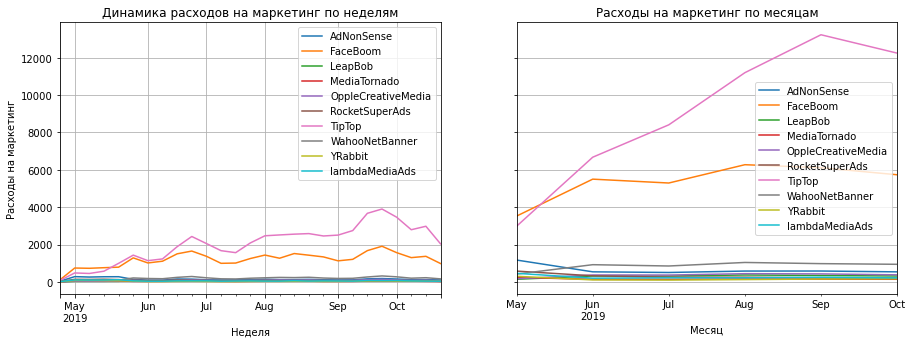

In [38]:
plt.figure(figsize=(30, 10))
ax1 = plt.subplot(1, 2, 1)
costs.pivot_table(index='week', columns='channel', values='costs', aggfunc='sum').plot(grid=True, figsize=(15, 5), ax=ax1)
plt.ylabel('Расходы на маркетинг')
plt.xlabel('Неделя')
ax1.set_title('Динамика расходов на маркетинг по неделям')
plt.legend()

ax2 = plt.subplot(1, 2, 2, sharey=ax1)
costs.pivot_table(
    index='month', columns='channel', values='costs', aggfunc='sum').plot(grid=True, figsize=(15, 5), ax=ax2)
plt.ylabel('Расходы на маркетинг')
plt.xlabel('Месяц')
ax2.set_title('Расходы на маркетинг по месяцам')
plt.legend()

plt.show()

Самые большие расходы идут на каналы TipTop и FaceBoom, причем расходы на канал TipTop все время растут, в начале периода они ниже, чем FaceBoom, а в конце значительно выше. Расходы на FaceBoom тоже выросли. Вложения в остальные источники по сравнению с названными, невелики. В начале периода можно выделить AdNonSense, но в конце мая вложения туда уменьшаются.
<br> Посмотрим на стоимость привлечения одного пользователя (CAC) по разным источникам

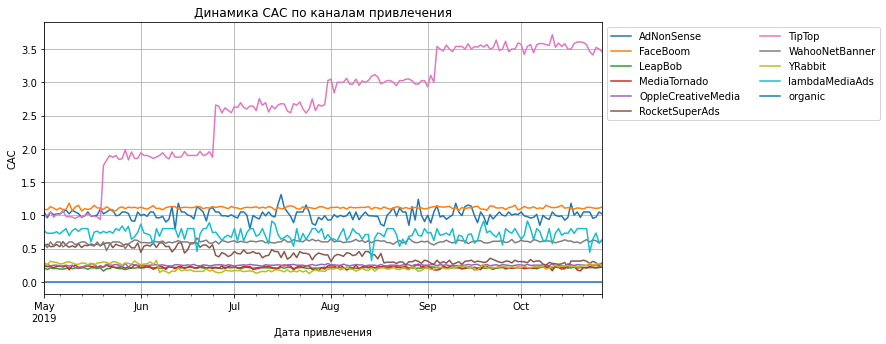

In [39]:
profiles.pivot_table(
    index='dt', columns='channel', values='acquisition_cost', aggfunc='mean'
).plot(grid=True, figsize=(10, 5))
plt.ylabel('CAC')
plt.xlabel('Дата привлечения')
plt.title('Динамика САС по каналам привлечения')
plt.legend(bbox_to_anchor=(1, 1), ncol=2)
plt.show()

На графике видно, что стоимость привлечения одного пользователя из TipTop растет почти каждый месяц, и к концу периода превышает стоимость привлечения из других источников минимум в 3 раза

In [40]:
(profiles
 .pivot_table(index='channel', values='acquisition_cost', aggfunc='mean')
 .reset_index()
 .rename({'acquisition_cost':'cac'}, axis=1)
)

,channel,cac
0,AdNonSense,1.008054
1,FaceBoom,1.113286
2,LeapBob,0.210172
3,MediaTornado,0.218717
4,OppleCreativeMedia,0.250000
5,RocketSuperAds,0.412095
6,TipTop,2.799003
7,WahooNetBanner,0.602245
8,YRabbit,0.218975
9,lambdaMediaAds,0.724802


Проанализировав расходы на маркетинг, мы видим, что самые большие расходы на одного пользователя в США, а самые маленькие - в Великобритании. Расходы в европейских странах сопоставимы. Больше всего денег потрачено на TopTop, но эффективность этих вложений постепенно снижалась в течение периода, а расходы на привлечение одного пользователя в этом канале росли до начала сентября, в то время как по другим каналам стоимость привлечения одного пользователя оставалась на одном уровне.

### Оценка окупаемости рекламы

Посмотрим на основные метрики, отражающие окупаемость вложений в рекламу. Для анализа возьмем горизонт планирования 14 дней и профили пользователей, пришедших из рекламных каналов. В качестве даты анализа установим 1 ноября 2019.

In [41]:
observation_date = datetime(2019, 11, 1).date()
horizon_days = 14
profiles = profiles.query('channel != "organic"')

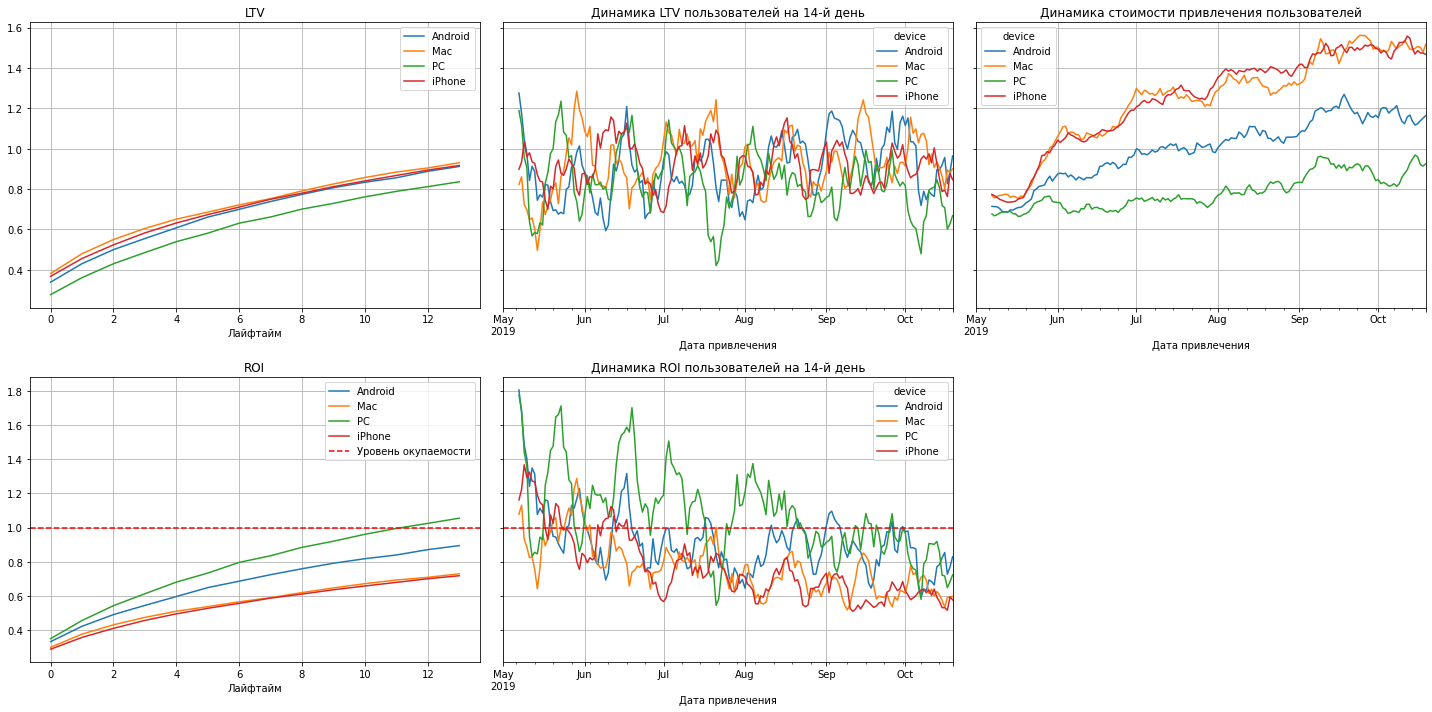

In [42]:
dimensions = ['device']

retention_raw, retention_grouped, retention_history = get_retention(profiles, visits, observation_date, horizon_days, dimensions = dimensions)
conversion_raw, conversion_grouped, conversion_history = get_conversion(profiles, orders, observation_date, horizon_days, dimensions = dimensions)
ltv_raw, ltv_grouped, ltv_history,  roi_grouped, roi_history = get_ltv(profiles, orders, observation_date, horizon_days, dimensions = dimensions)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

По графикам мы можем сделать следующие выводы:
- в среднем пользователь, пришедший через рекламный канал, к 14 дню приносит компании 0.9 у.е.
- стоимость привелечения пользователей резко растет середины мая и потом увеличивается скачками в конце каждого месяца, кроме октября
- вложения в маркетинг окупаются только на 80%
- в динамике инвестиции в начале периода окупались, но, с середины июня перестали окупаться.

#### конверсия

Посмотрим внимательнее на конверсию. Чтобы избавиться от шумов, выставим ширину окна 35

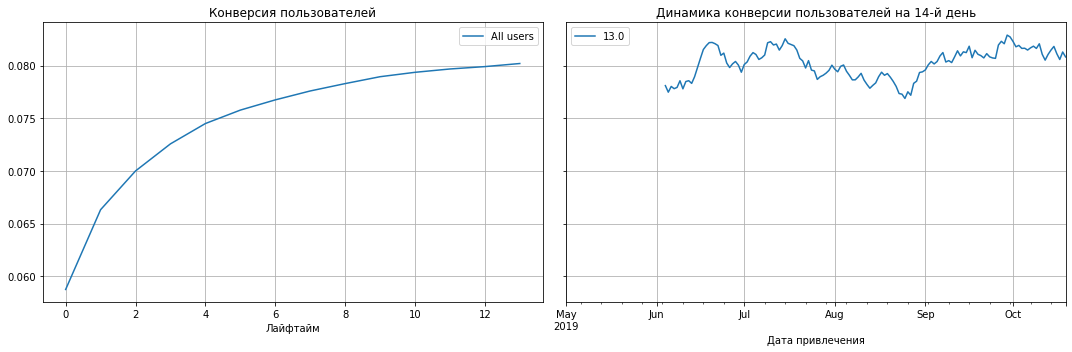

In [44]:
dimensions=[]
conversion_raw, conversion, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions, ignore_horizon=False
)

plot_conversion(conversion, conversion_history, horizon_days, window=35)

Средний показатель конверсии среди пользователей, привлеченных с помощью рекламы, 8% на 14-й день. Лечшие показатели можно было наблюдать в середине июня и в начале октября. Самый большой спад пришелся на конец августа.

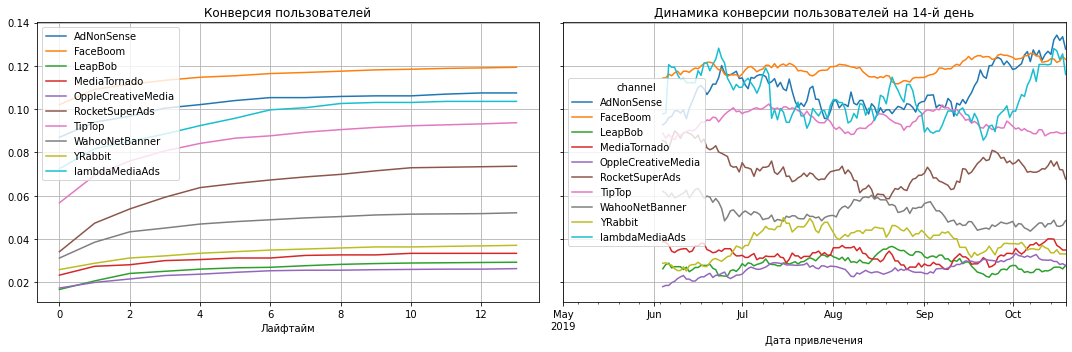

In [45]:
dimensions=['channel']
conversion_raw, conversion, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions, ignore_horizon=False
)

plot_conversion(conversion, conversion_history, horizon_days, window=35)

Самая высокая конверсия у пользователей, пришедших из FaceBoom (10% в начале периода, 12 % в конце). Также неплохие показатели у каналов AdNonSense и lambdaMediaAds. TipTop, на который уходит наибольшая часть инвестиций, занимает по конверсии 4 место и к 14 дню лайфтайма показывает конверсию около 9%

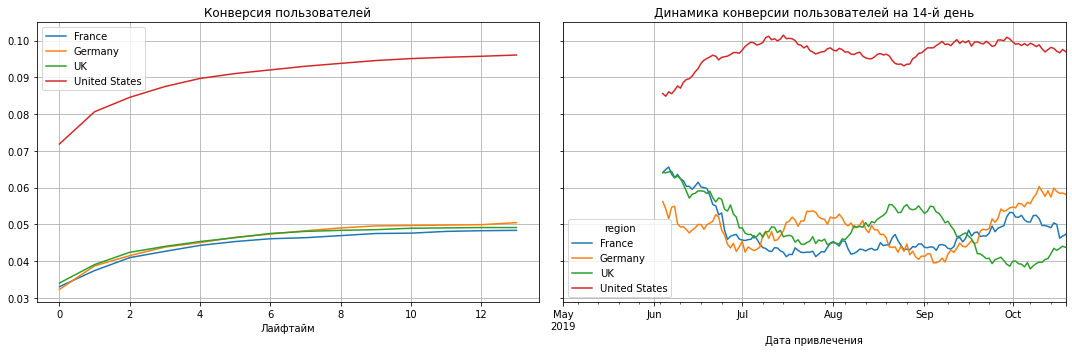

In [46]:
dimensions=['region']
conversion_raw, conversion, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions, ignore_horizon=False
)

plot_conversion(conversion, conversion_history, horizon_days, window=35)

В разрезе регионов самая высокая конверсия в США - 9.5% на 14-й день. В европейских странах показатели конверсии практически идентичны, к 14-му дню они нахходятся в районе 5%. В динамике значительный рост в США наблюдается в середине июня. В Германии есть пики во второй половине июля и в октябре, в Великобритании самый большой рост во второй половине августа. 

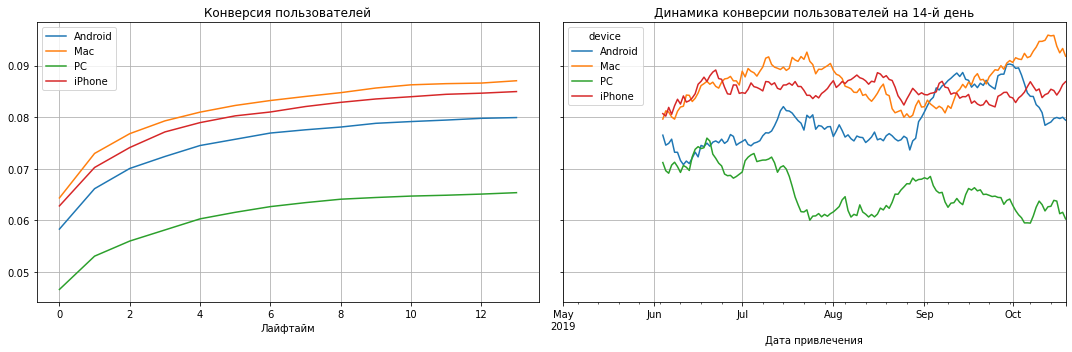

In [47]:
dimensions=['device']
conversion_raw, conversion, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions, ignore_horizon=False,
)

plot_conversion(conversion, conversion_history, horizon_days, window=35)

Если разделить пользователей по устройствам, самая большая конверсия на Mac (более 8% на 14-й день), самая маленькая - на PC (менее 7%)

#### удержание

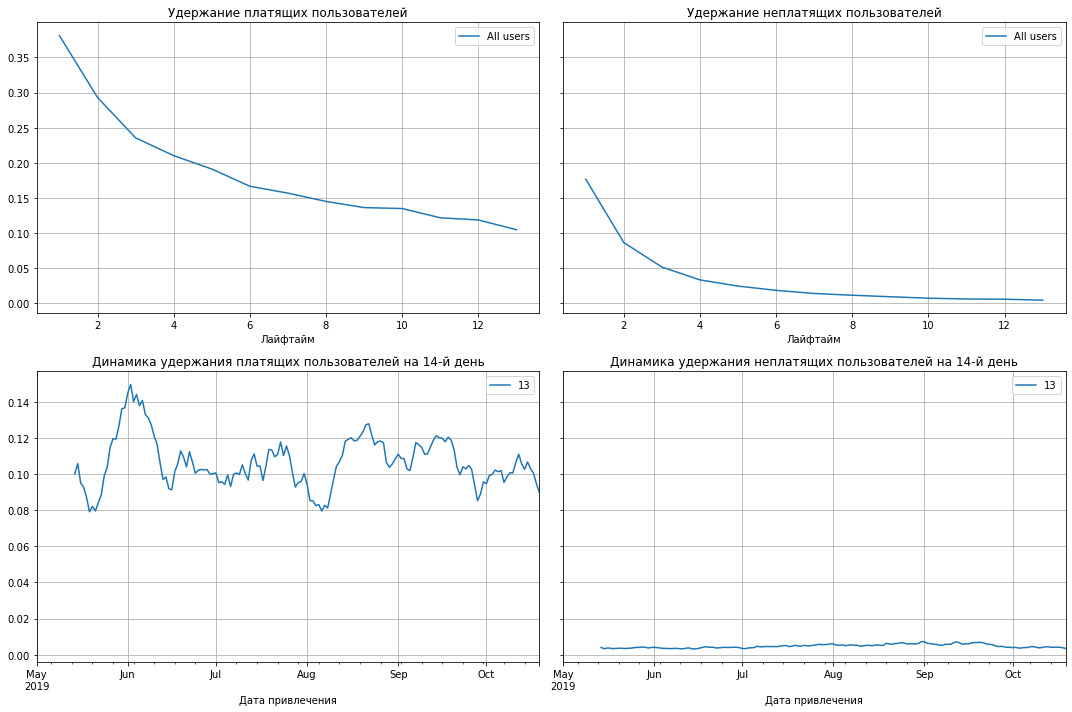

In [48]:
dimensions = []

retention_raw, retention, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions = dimensions, ignore_horizon = False
)

plot_retention(retention, retention_history, horizon_days, window=14)

Удержание платящих пользователей в 1-й день лайфтайма превышает 35% и снижается к 14-му дню до 10%. В динамике на 14-й день лучший результат зафиксирован в начале июня - 15%. Самый низкий уровень удержания наблюдается в середине мая и начале августа - 8%. Среди неплатящих пользователей на второй день установки в приложение заходят 17% пользователей, а удержание 14-го дня близко к нулю.

Посмотрим на показатели удержания в разрезе каналов привлечения. Возьмем ширину окна сглаживания 14 дней.

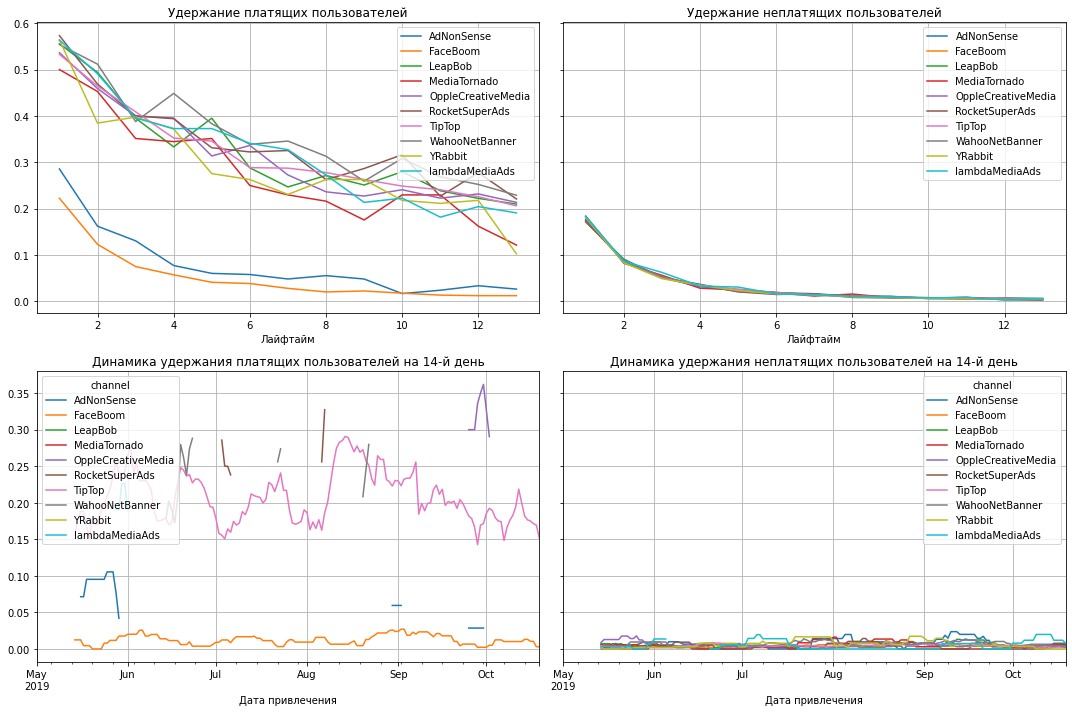

In [49]:
dimensions = ['channel']

retention_raw, retention, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions = dimensions, ignore_horizon = False
)

plot_retention(retention, retention_history, horizon_days, window=14)

На графике видно, что удержание пользователей, приходящих из FaceBoom ниже 5%. Стоит обратить внимание на инвестиции в этот источник. При этом, у FaceBoom самый высокий показетель конверсии.

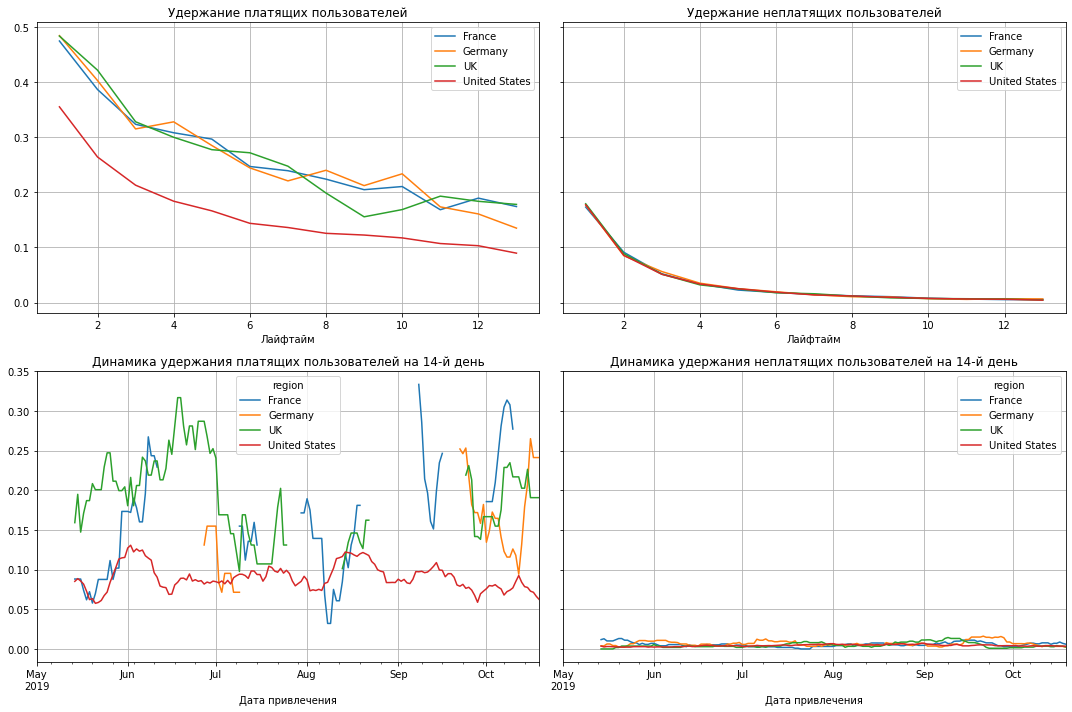

In [50]:
dimensions = ['region']

retention_raw, retention, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions = dimensions, ignore_horizon = False
)

plot_retention(retention, retention_history, horizon_days, window=14)

Если рассматривать те же данные в разрезе регионов, видно, что в США, откуда приходит самая большая часть пользователей, удержание клиентов меньше, чем в европейских странах.

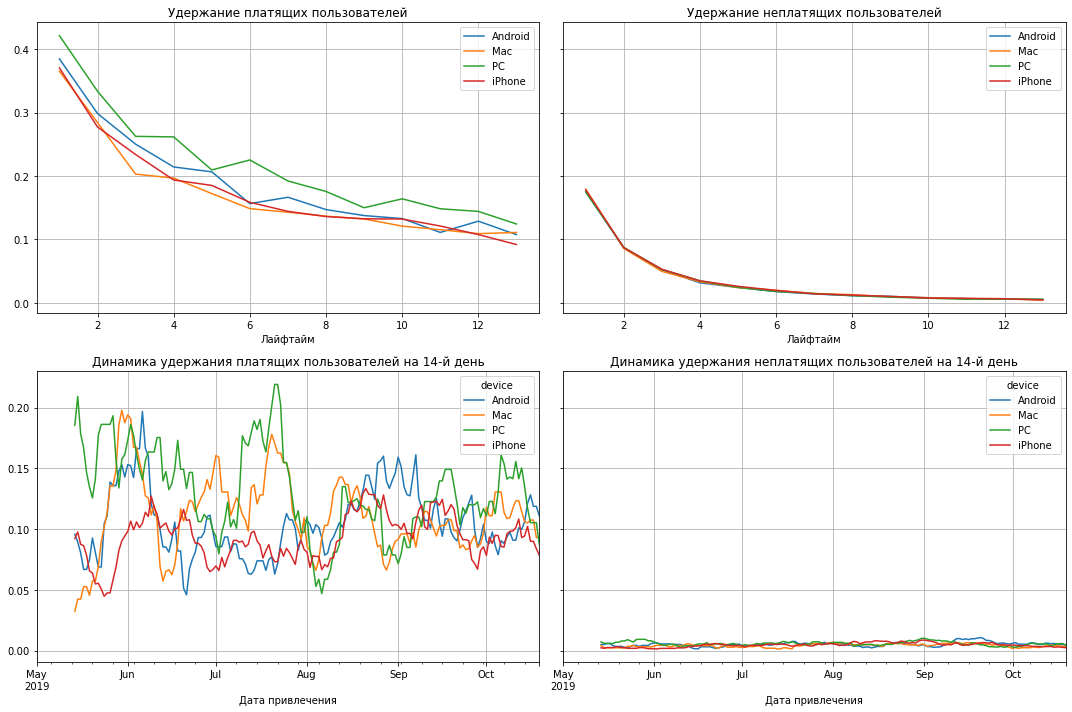

In [51]:
dimensions = ['device']

retention_raw, retention, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions = dimensions, ignore_horizon = False
)

plot_retention(retention, retention_history, horizon_days, window=14)

С точки зрения устройств, с которых люди заходят в приложение, самое высокое удержание среди платящих пользователейу пользователей на PC. Остальные устройства показывают похожий уровень удержания.

#### LTV

Для оценки LTV возьмем окно сглаживания 30 дней

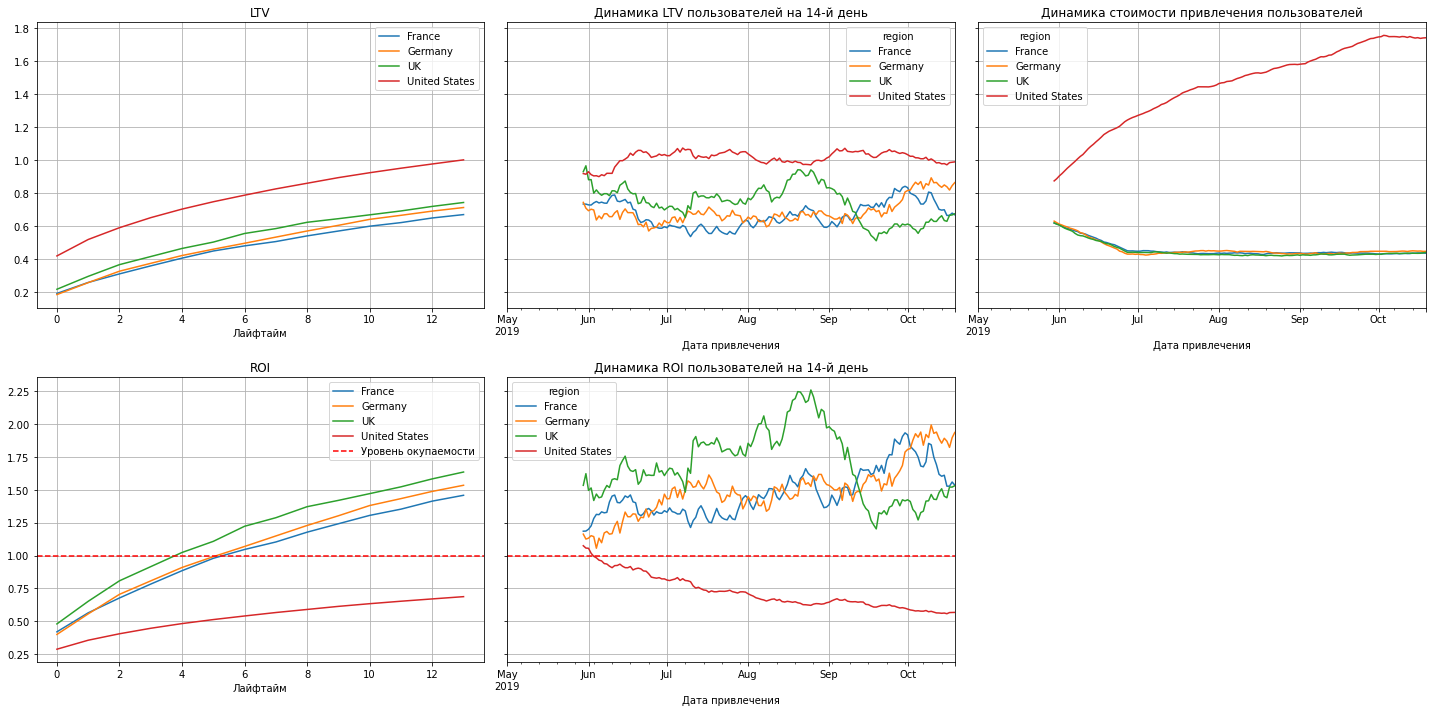

In [52]:
dimensions=['region']

ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions, ignore_horizon=False,)

plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window=30)

За 14 дней после регистрации больше всего денег приносят пользователи из США. При этом, стоимость привлечения клиентов из этой страны за изучаемый период растет так сильно, что вложения не окупаются. В европейских странах вложения в маркетинг окупаются на 4-6 день

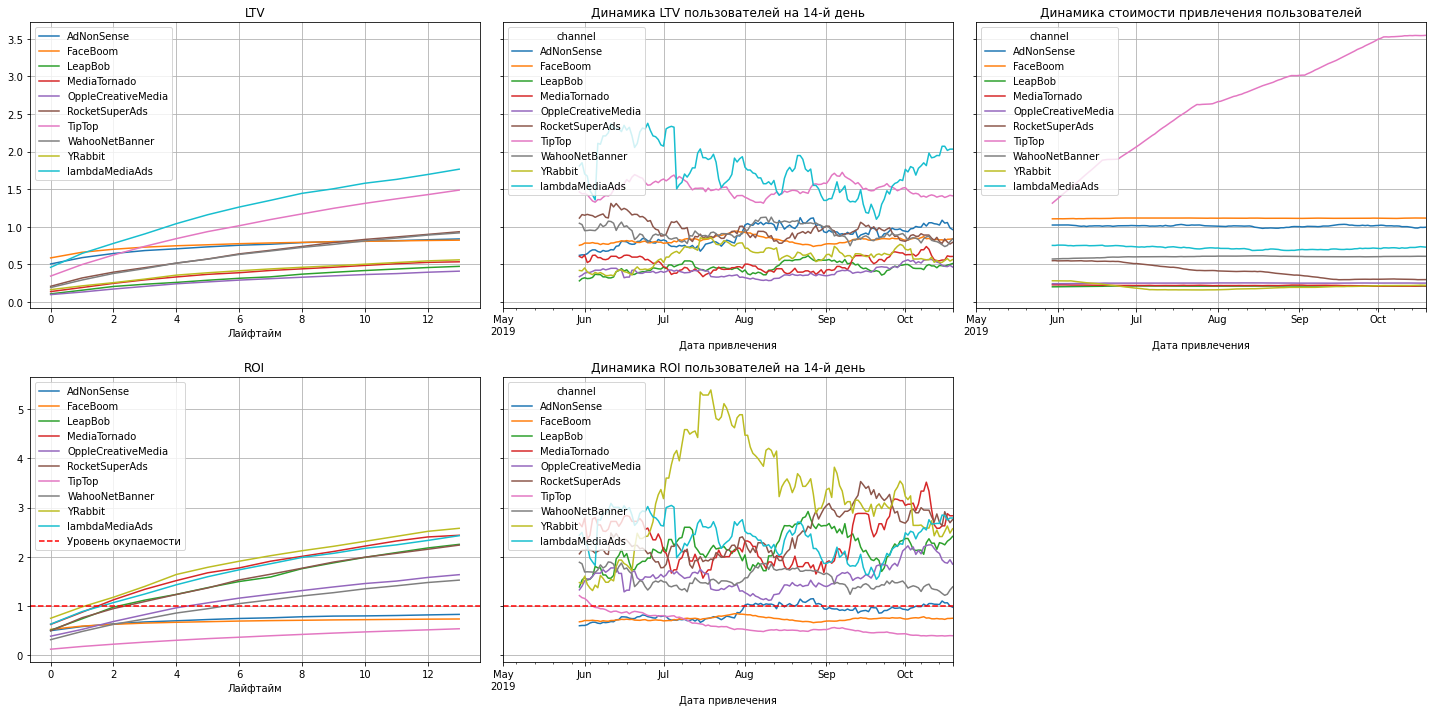

In [53]:
dimensions=['channel']

ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions, ignore_horizon=False,)

plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window=30)

В разбивке по каналам мы видим, что не окупаются вложения в TipTop, FaceBoom и AdNonSense не окупаются на 14 день. А это каналы, которые привлекают большое количество клиентов с высокой конверсией.

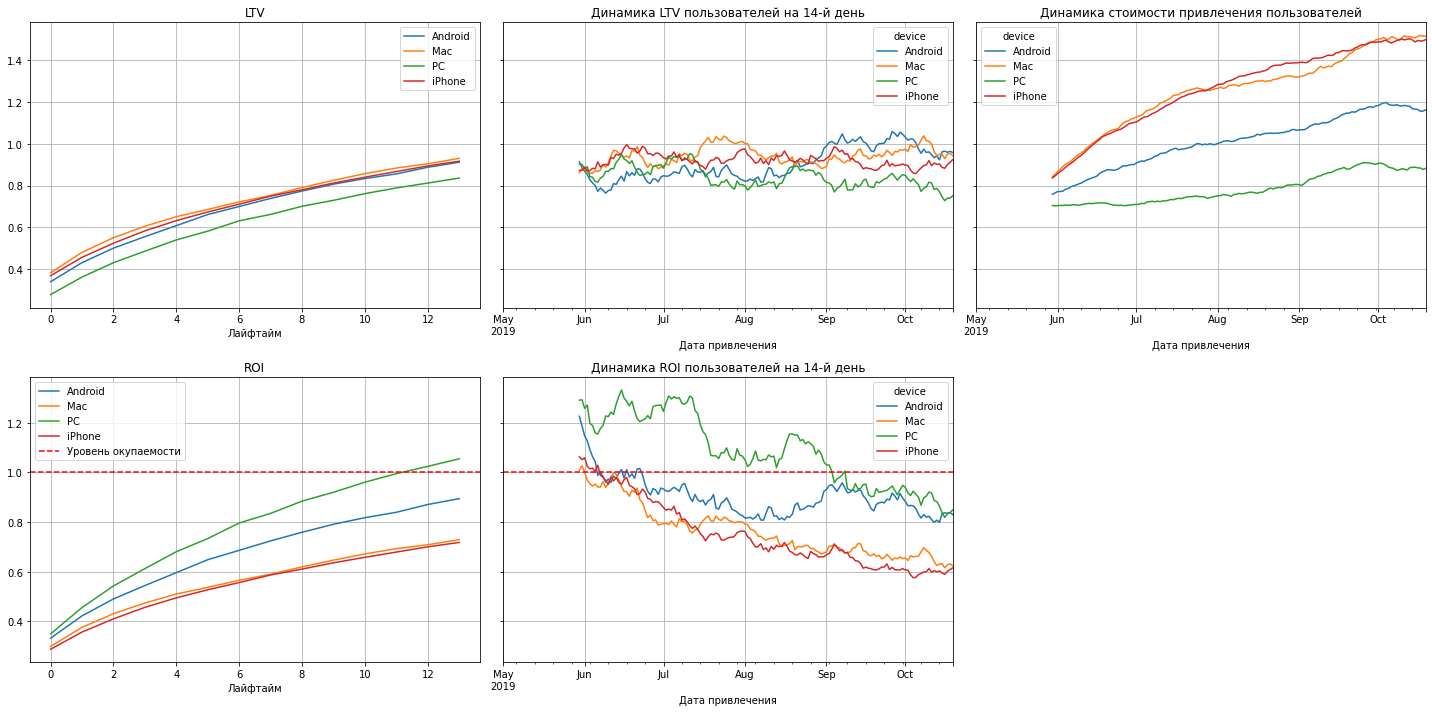

In [54]:
dimensions=['device']

ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions, ignore_horizon=False,)

plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window=30)

В разбивке по устройствам видно, что меньше всего денег приносят пользователи на PC, но это единственный тип устройства, инвестиции в который окупаются. Привлечение пользователей Iphone, Mac и Android стоит дороже, чем приложение может заработать на их покупках. Посмотрим внимательнее на пользователей из США - самого большого и проблемного рынка.

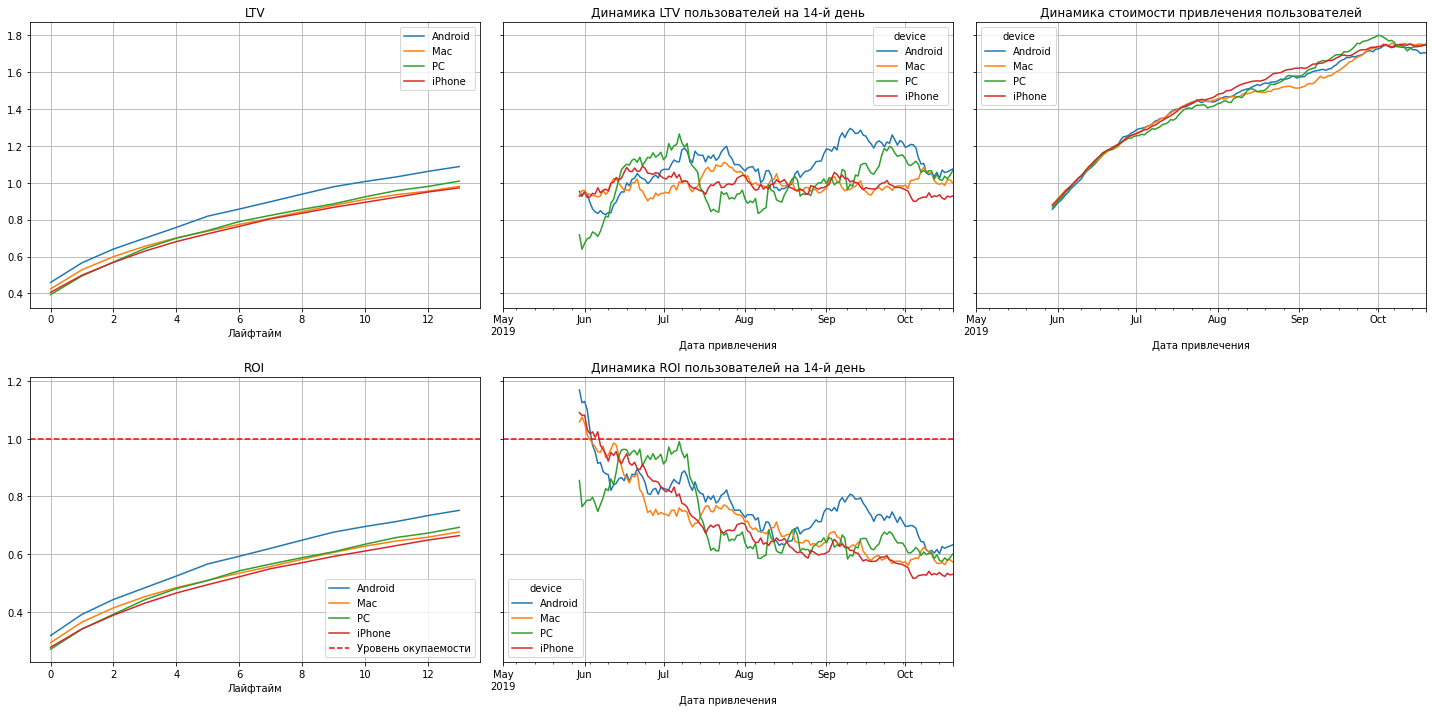

In [55]:
profiles_us = profiles.query('region == "United States"')

dimensions=['device']

ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles_us, orders, observation_date, horizon_days, dimensions=dimensions, ignore_horizon=False,)

plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window=30)

Среди пользователей из США больше всего денег приносят те,  кто пользуется андроидом. Стоимость провлечения клиентов на всех устройствах растет примерно одинаково и ни на одном устройстве инвестиции не окупаются. Посмотрим внимательнее на разбивку по каналам внутри США.

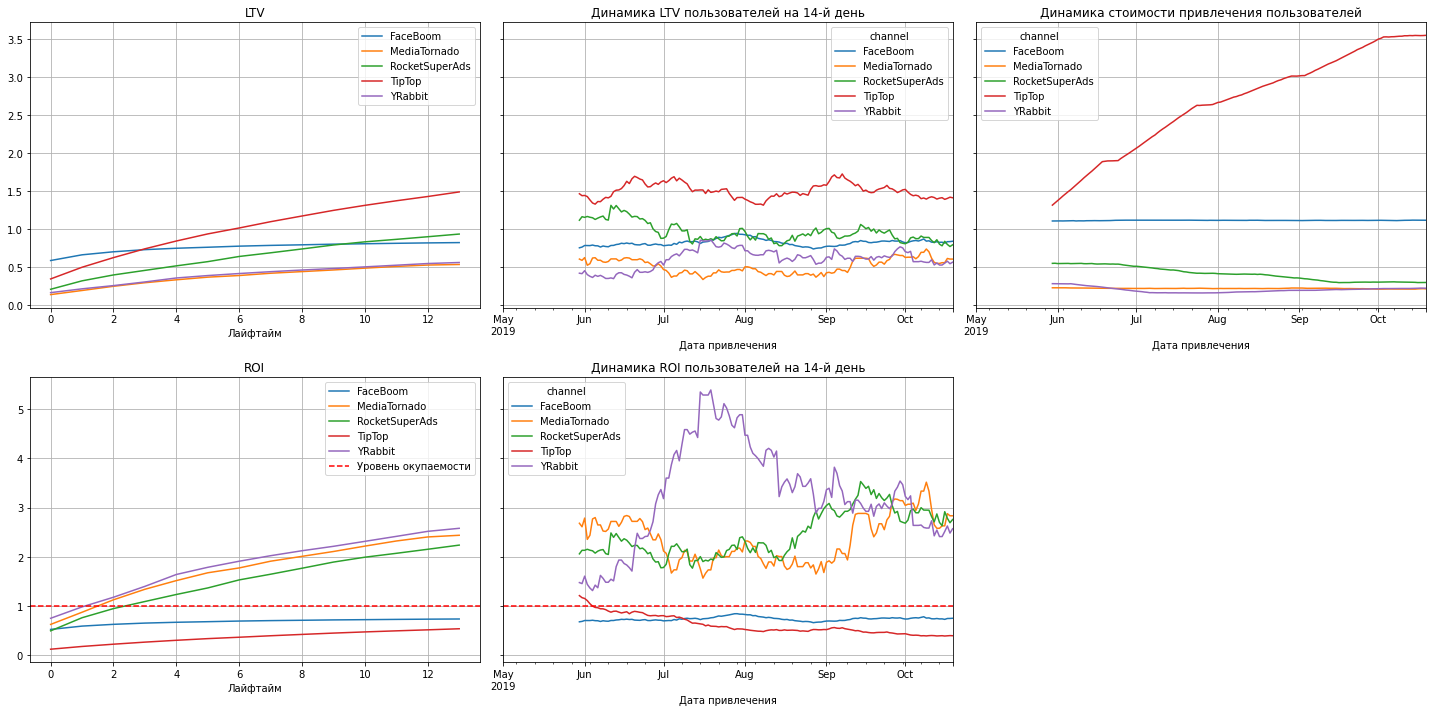

In [56]:
dimensions=['channel']

ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles_us, orders, observation_date, horizon_days, dimensions=dimensions, ignore_horizon=False,)

plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window=30)

Источники FaceBoom и TipTop не окупаются. Посмотрим на те  же метрики в США без этих каналов.

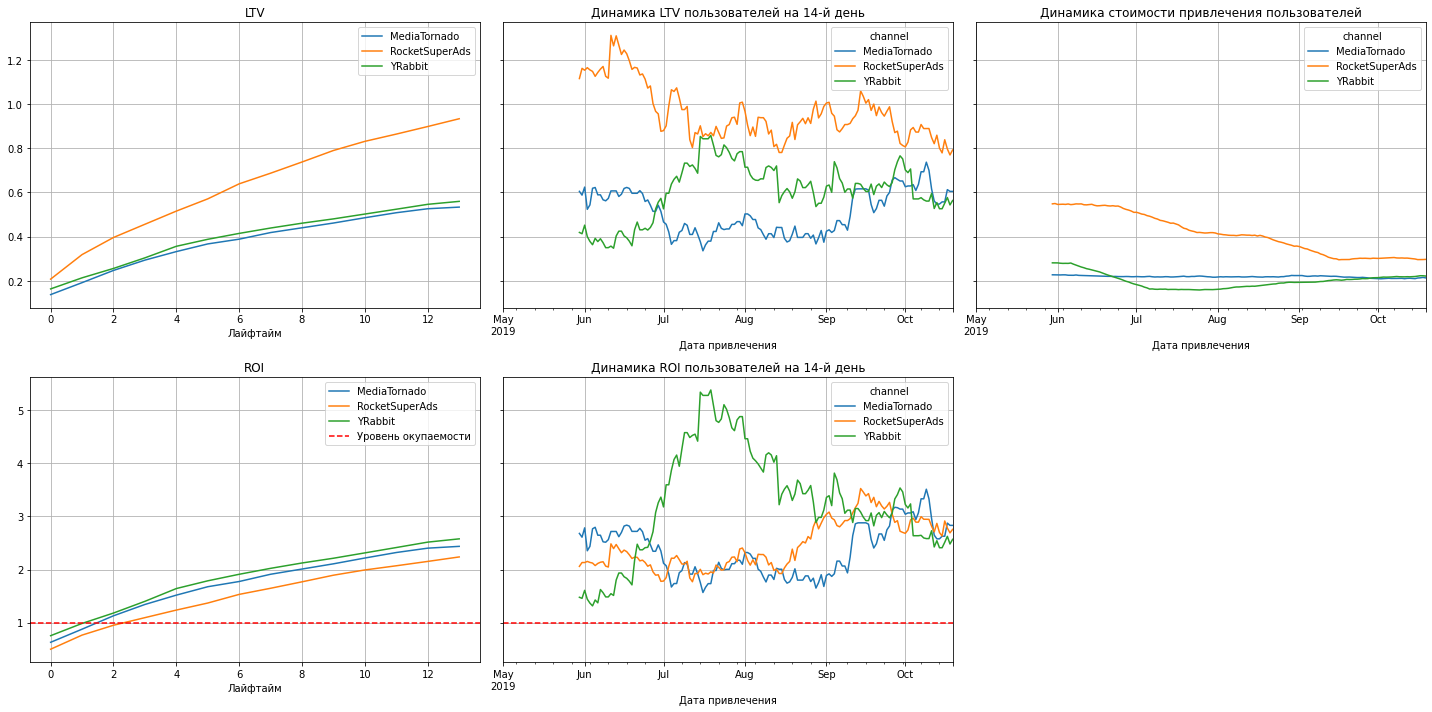

In [57]:
profiles_2 = profiles.query('region == "United States" and channel != "TipTop" and channel != "FaceBoom"')

dimensions=['channel']

ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles_2, orders, observation_date, horizon_days, dimensions=dimensions, ignore_horizon=False,)

plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window=30)

In [58]:
profiles_2.groupby('channel').agg({'user_id':'count','payer':'mean'}).reset_index().sort_values(by='payer', ascending=False)

,channel,user_id,payer
1,RocketSuperAds,4448,0.079137
2,YRabbit,4312,0.038265
0,MediaTornado,4364,0.035747


В США есть каналы,  которые окупаются. Конечно, без гигантов количество пользователей в США быстро сократится, но, возможно, позитивный опыт небольших каналов получится масштабировать для больших площадок.

Посмотрим, как обстоят дела на европейских рынках

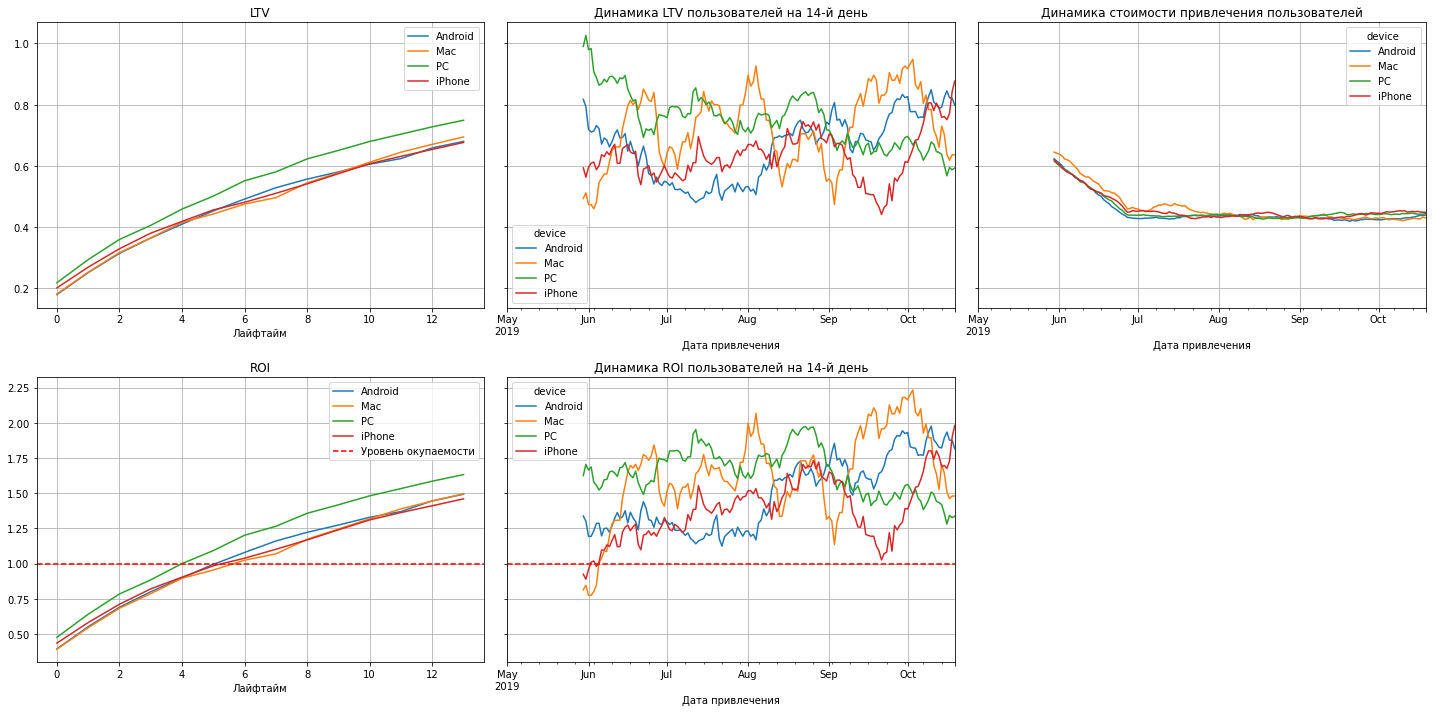

In [59]:
profiles_not_us = profiles.query('region != "United States"')

dimensions=['device']

ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles_not_us, orders, observation_date, horizon_days, dimensions=dimensions, ignore_horizon=False,)

plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window=30)

В других регионах окупаются пользователи вне зависимости от устройства, значит, дело не в девайсе. Посмотрим на европейские рынки в разрезе каналов привлечения.

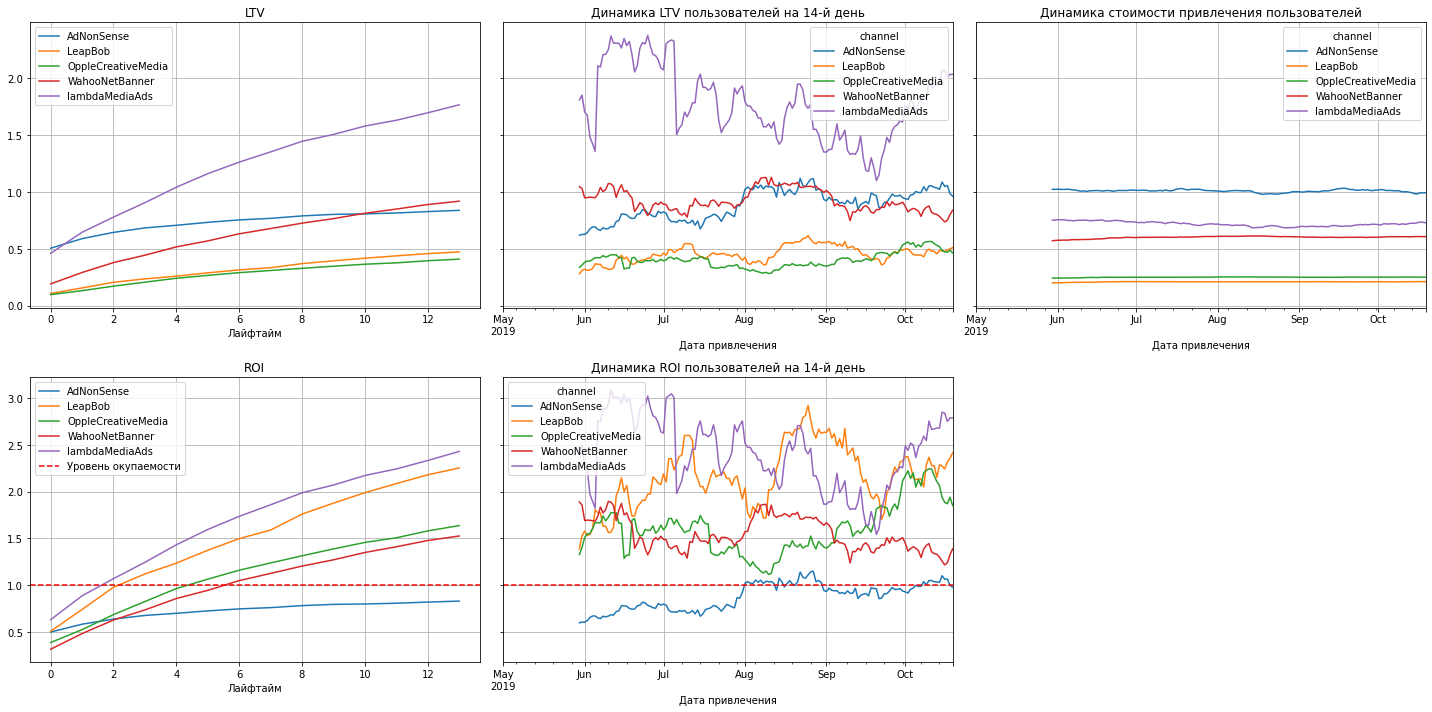

In [60]:
dimensions=['channel']

ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles_not_us, orders, observation_date, horizon_days, dimensions=dimensions, ignore_horizon=False,)

plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window=30)

На европейских рынках тоже есть канал, инвестиции в который не окупаются. Это AdNonSense. Посмотрим внимательнее на проблемные каналы.

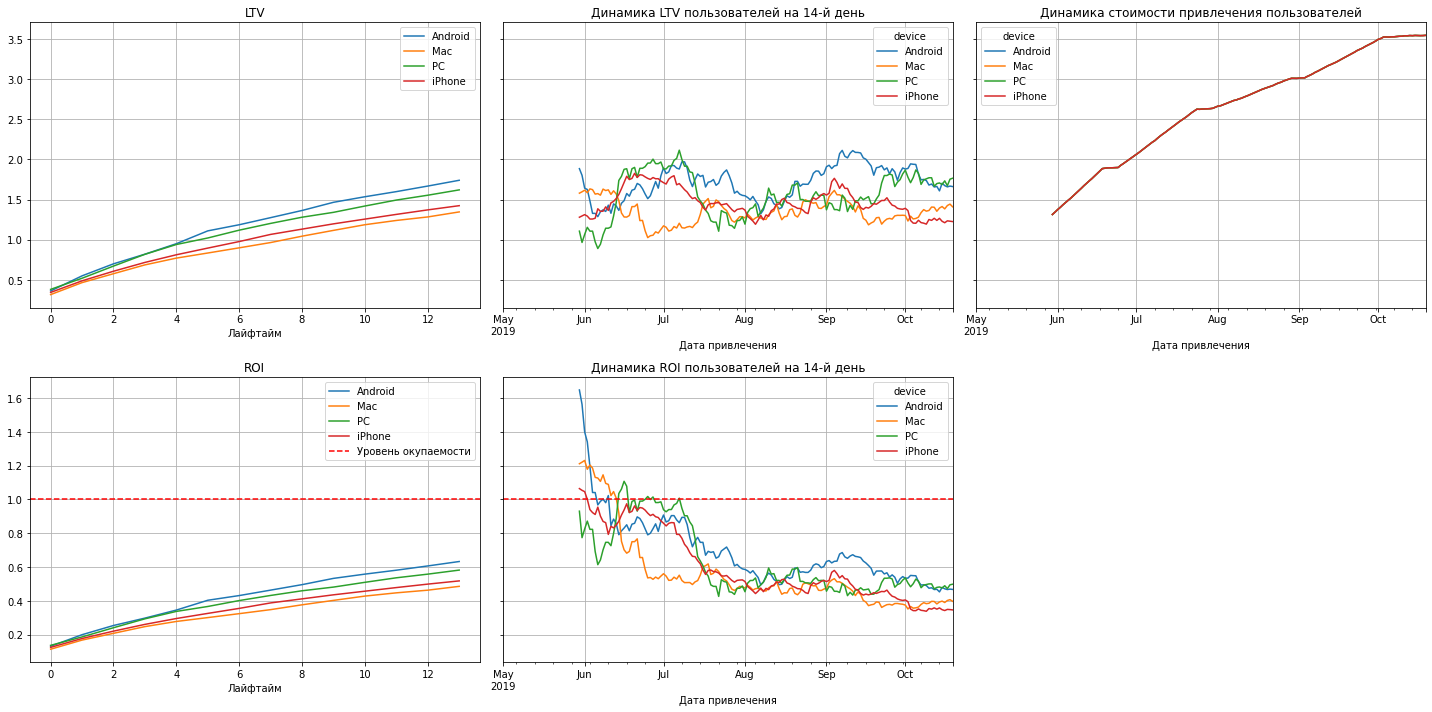

In [61]:
profiles_tiptop = profiles.query('channel == "TipTop"')

dimensions=['device']

ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles_tiptop, orders, observation_date, horizon_days, dimensions=dimensions, ignore_horizon=False,)

plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window=30)

Инвестиции в привлечение через TipTop не окупаются ни на одном устройстве. LTV растет на протяжении 14 дней, но стоимость рекламы так высока, что ни больше количество клиентов, ни хорошая конверсия не окупают этих вложений. Стоит отметить, что до июня расходы частично окупались, но после эффективность инвестиций начала снижаться.

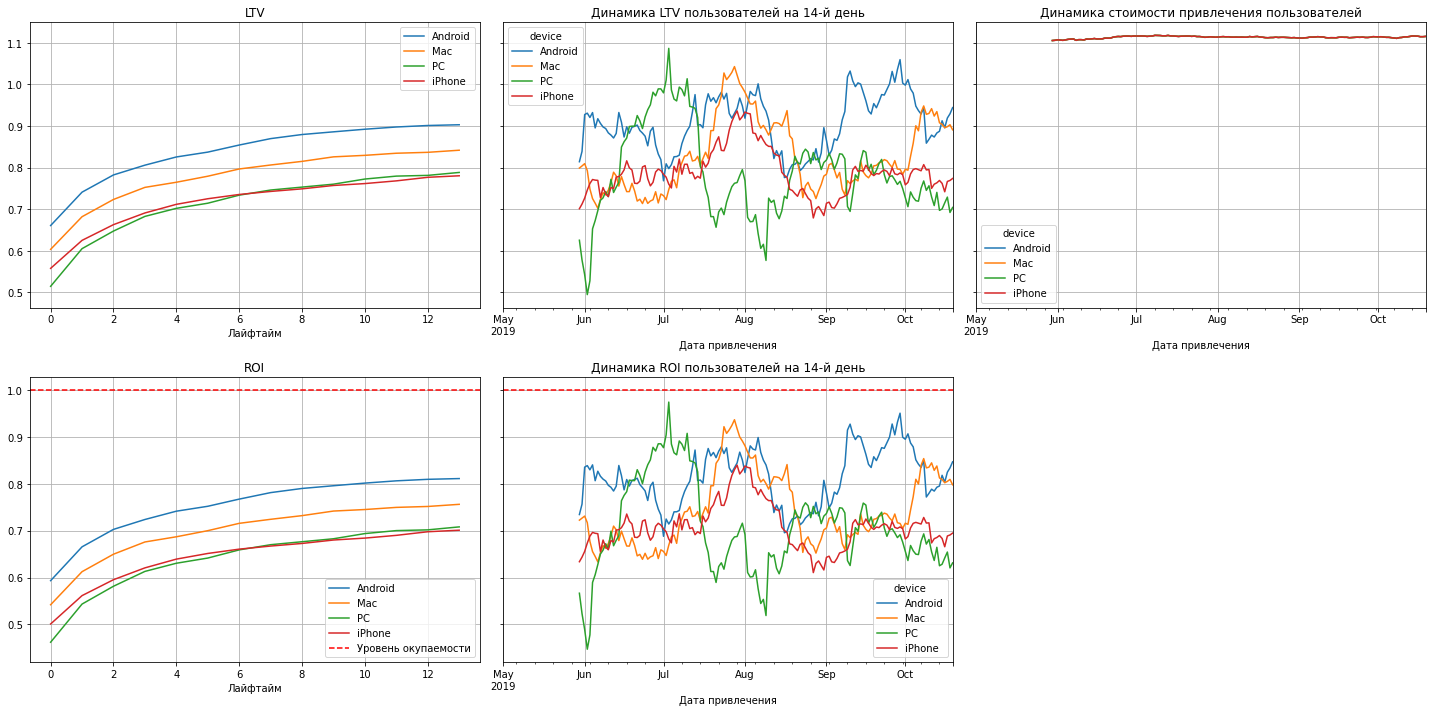

In [62]:
profiles_fb = profiles.query('channel == "FaceBoom"')

dimensions=['device']

ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles_fb, orders, observation_date, horizon_days, dimensions=dimensions, ignore_horizon=False,)

plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window=30)

Затраты на рекламу в этом сегменте стабильно высокие и не перекрываются покупками привлеченных пользователей. Если TipTop хорошо окупался в начале периода, FaceBoom всегда приносил денег меньше, чем было вложено.

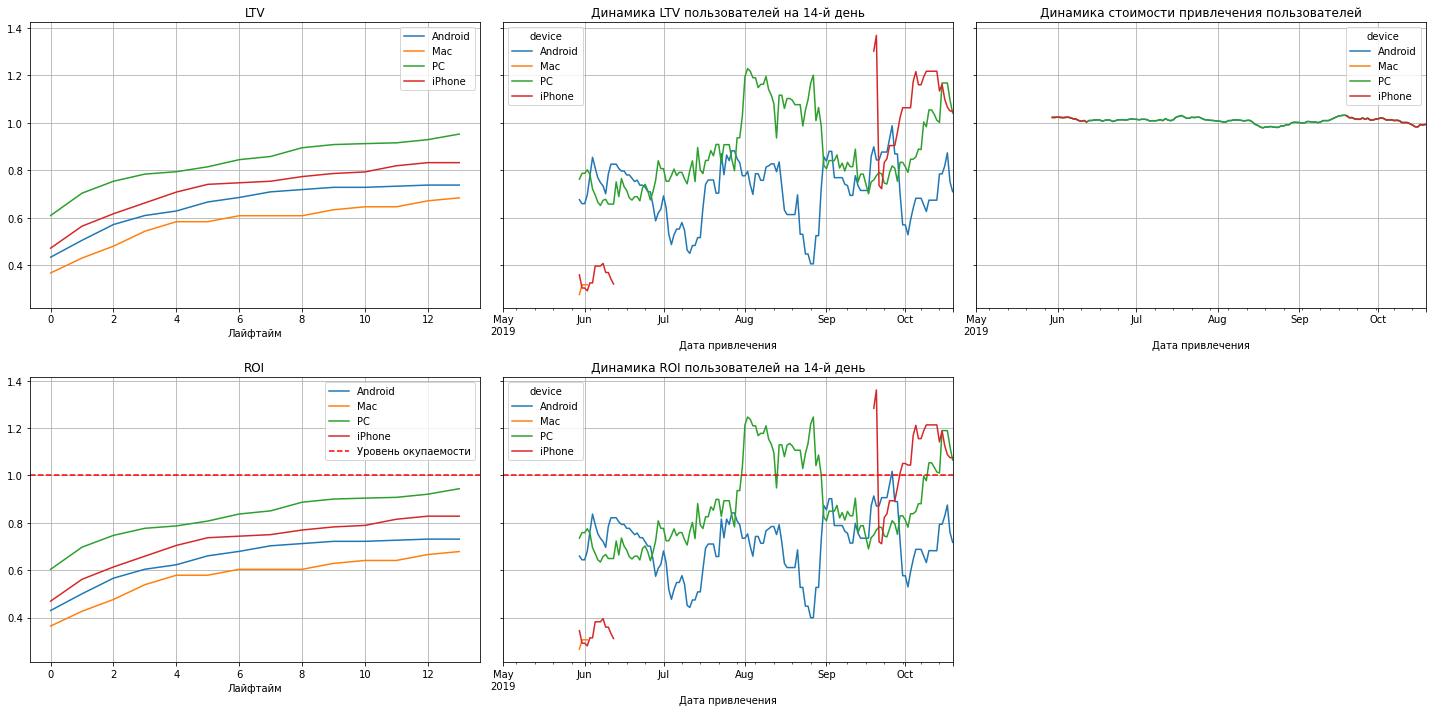

In [63]:
profiles_ans = profiles.query('channel == "AdNonSense"')

dimensions=['device']

ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles_ans, orders, observation_date, horizon_days, dimensions=dimensions, ignore_horizon=False,)

plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window=30)

По графикам видно, что AdNonSence в какой-то момент начинал окупаться на PC и на IPhone. Стоит изучить активности в этот период, возмножно, удастся откорректировать маркетинговую стратегию так, чтобы сделать канал эффективным.

Посмотрим, как выглядит окупаемость инвестиций, если убрать из выборки все проблемные каналы 

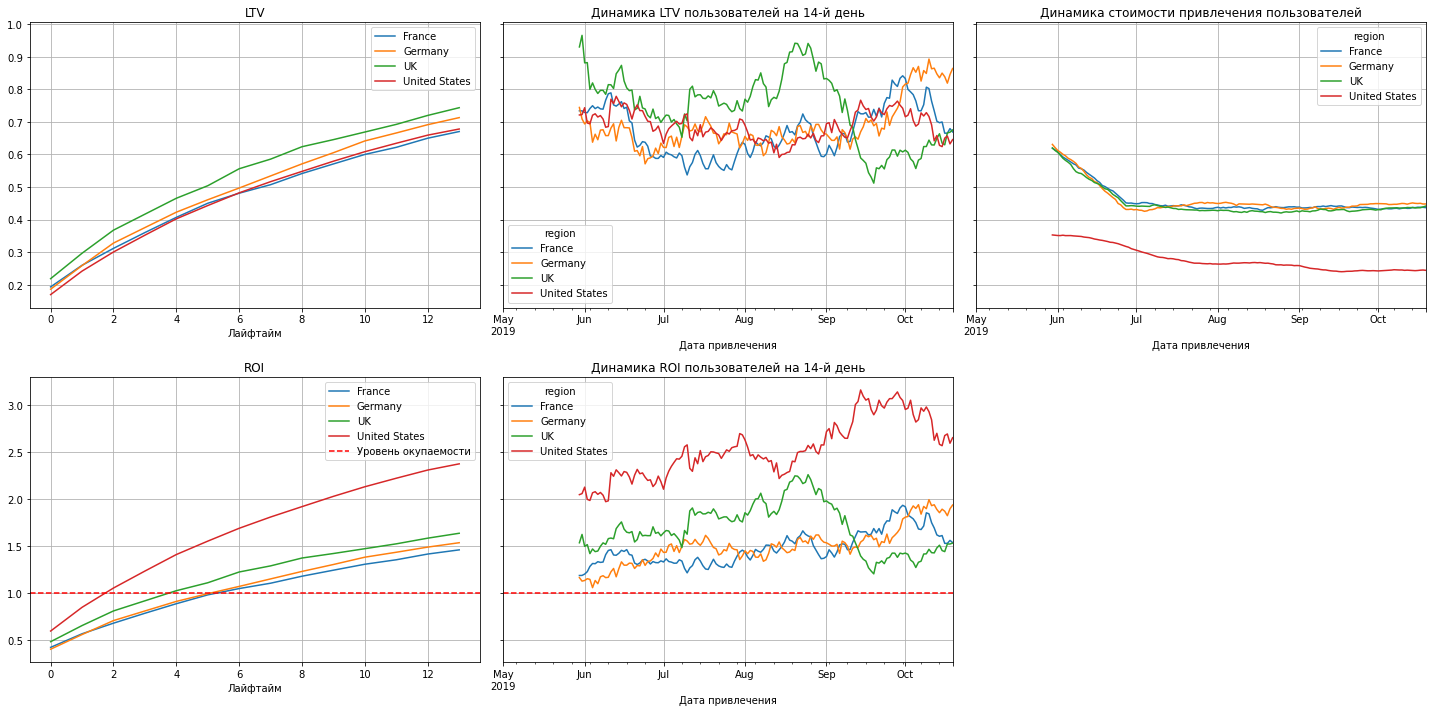

In [64]:
profiles_1 = profiles.query('channel != "TipTop" and channel != "FaceBoom" and channel != "AdNonSence"')

dimensions=['region']

ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles_1, orders, observation_date, horizon_days, dimensions=dimensions, ignore_horizon=False,)

plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window=30)

Без каналов, инвестиции в которые не окупаются, США выходит в плюс на второй день лайфтайма, европейские рынки становятся прибыльными на 4-6 день. Проблема только в том, что убыточны самые большие каналы, без них охват рекламы будет значительно скромнее.

### Вывод

Неэффективными оказались самые большие каналы привлечения пользователей с хорошими показателями конверсии. Это популярные площадки с высокой стоимостью рекламы, и затраты, которые были вложены, не окупились большим количеством пользователей, среди которых было много покупателей.

Для улучшения маркетинговых показателей можно дать следующие рекомендации:
- проверить, нет ли у пользователей FaceBoom технических проблем при переходе в приложение, поскольку у этого источника очень низкий уровень удержания
- попробовать настроить таргетинг таким образом, чтобы реклама на площадках TipTop, FaceBoom и AdNonSence привлекала больше пользователей
- стоит обратить внимание на каналы lambdaMediaAds, RocketSuperAds и WahooNetBanner, эти каналы привлечения можно назвать эффективными. Возможно, опыт задесь можно масштабировать на гигантов.
- если не получится грамотно настроить таргетинг, от каналов TipTop, FaceBoom и AdNonSence рекомендуется отказаться как от убыточных.